In [1]:
#here we will apply a simple threshold (yen method) binarisation to the data set in order to create a mask

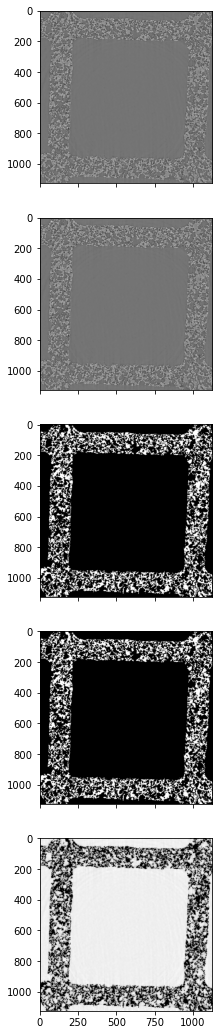

In [2]:
#Imports 
import numpy as np
import matplotlib.pyplot as plt
import imageio as io
from skimage import data, img_as_float
from skimage.io import imread_collection
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.util import crop
from skimage.morphology import binary_erosion, binary_dilation, cube
from skimage import filters
from skimage.filters import gaussian

#Read in data for zeroth volume. This will be used as mask for the filter/cat phase.
vol_0 = img_as_float(crop(io.volread('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B0X.tif'), ((0, 1055),(0, 0), (0, 0)), copy=True))

#2d wise non local means
sigma_est = np.mean(estimate_sigma(vol_0, multichannel=False))
for z in range(1055):
    vol_0[z] = denoise_nl_means(vol_0[z], h=4*sigma_est, fast_mode=True,
                                  patch_size=9, patch_distance=5, multichannel=False)
vol_0_nlm = vol_0 * 255

#Gaussian Filter
vol_0_gaussian = gaussian(vol_0_nlm, sigma=0.20, output=None, mode='nearest', cval=0, multichannel=False, preserve_range=True, 
                        truncate=4.0)

#Apply binary threshold 1
thresh_yen_vol1 = filters.threshold_yen(vol_0_gaussian.astype('uint8'))
segmented_yen_vol_0 = vol_0_gaussian.astype('uint8') > thresh_yen_vol1 + 2

#Erosion/Dilation of binary 1
segmented_yen_eroded_vol_0_1=binary_erosion(segmented_yen_vol_0, cube(1))
segmented_yen_eroded_vol_0_2=binary_erosion(segmented_yen_eroded_vol_0_1, cube(1))
segmented_yen_eroded_vol_0=binary_erosion(segmented_yen_eroded_vol_0_2, cube(1))
segmented_yen_eroded_dilated_vol_0_1=binary_dilation(segmented_yen_eroded_vol_0, cube(1))
segmented_yen_eroded_dilated_vol_0_2=binary_dilation(segmented_yen_eroded_dilated_vol_0_1, cube(1))
#segmented_yen_eroded_dilated_vol_0_3=binary_dilation(segmented_yen_eroded_dilated_vol_0_2, cube(1))
segmented_yen_eroded_dilated_vol_0=binary_dilation(segmented_yen_eroded_dilated_vol_0_2, cube(1))

#Create mask
mask = 1 - segmented_yen_eroded_dilated_vol_0
#mask = 1 - segmented_yen_vol_0
masked_0 = vol_0_gaussian * mask

#Plot images of raw, filtered, threshold, threshold wt erosion/dilation
fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (60, 18.4), 
                         sharex=True, sharey=True)
axes[0].imshow(vol_0[4], cmap = 'gray')
axes[1].imshow(vol_0_nlm[4], cmap = 'gray')
axes[2].imshow(segmented_yen_vol_0[4], cmap = 'gray')
axes[3].imshow(segmented_yen_eroded_dilated_vol_0[4], cmap='gray')
axes[4].imshow(masked_0[4], cmap='gray')

In [3]:
#happy with the mask, save it.
#have to save as 2d slices to save memory
for y in range(0, 1055):
    io.imwrite('E:/paper_2/Volumes_Bare/Mask_TiffSaver/TiffSaver_%d.tif'%(y), mask[y].astype('Float32'), format='tiff')
    #io.imwrite('E:/paper_2/Volumes_Bare/Masked_TiffSaver/TiffSaver_%d.tif'%(y), masked_0[y].astype('uint8'), format='tiff')

<ipython-input-3-95832c9008bf>:4: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  io.imwrite('E:/paper_2/Volumes_Bare/Mask_TiffSaver/TiffSaver_%d.tif'%(y), mask[y].astype('Float32'), format='tiff')


In [4]:
#this is then loaded into avizo so that streaking artifacts can be removed manually